### Event Distribution of Mice with Time

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Basic Data Cleaning

In [25]:
# read csv file in
filename = 'FED000_071123_06.CSV'
file_lists = filename.split(sep='_')
group_name = file_lists[2][:2]

df = pd.read_csv(filename)

In [26]:
# define the cleaning function
def mice_csv_clean(to_clean):
    cleaned = to_clean[['MM:DD:YYYY hh:mm:ss', 'Event', 'Active_Poke']].rename(
        columns={'MM:DD:YYYY hh:mm:ss': 'Time_Stamp'})

    # replace all left-related tags to left and right-related tags to right
    cleaned = cleaned.replace({'LeftWithPellet': 'Left', 'LeftDuringDispense': 'Left',
                                       'RightWithPellet': 'Right', 'RightDuringDispense': 'Right'})

    # Convert Time_Stamp column to datetime format for processing
    cleaned['Time_Stamp'] = pd.to_datetime(cleaned['Time_Stamp'])
    return cleaned

In [27]:
# perform cleaning
data_dropped = mice_csv_clean(df)

#### Graphing

#### Graphing Process

In [28]:
import matplotlib.patches as mpatches

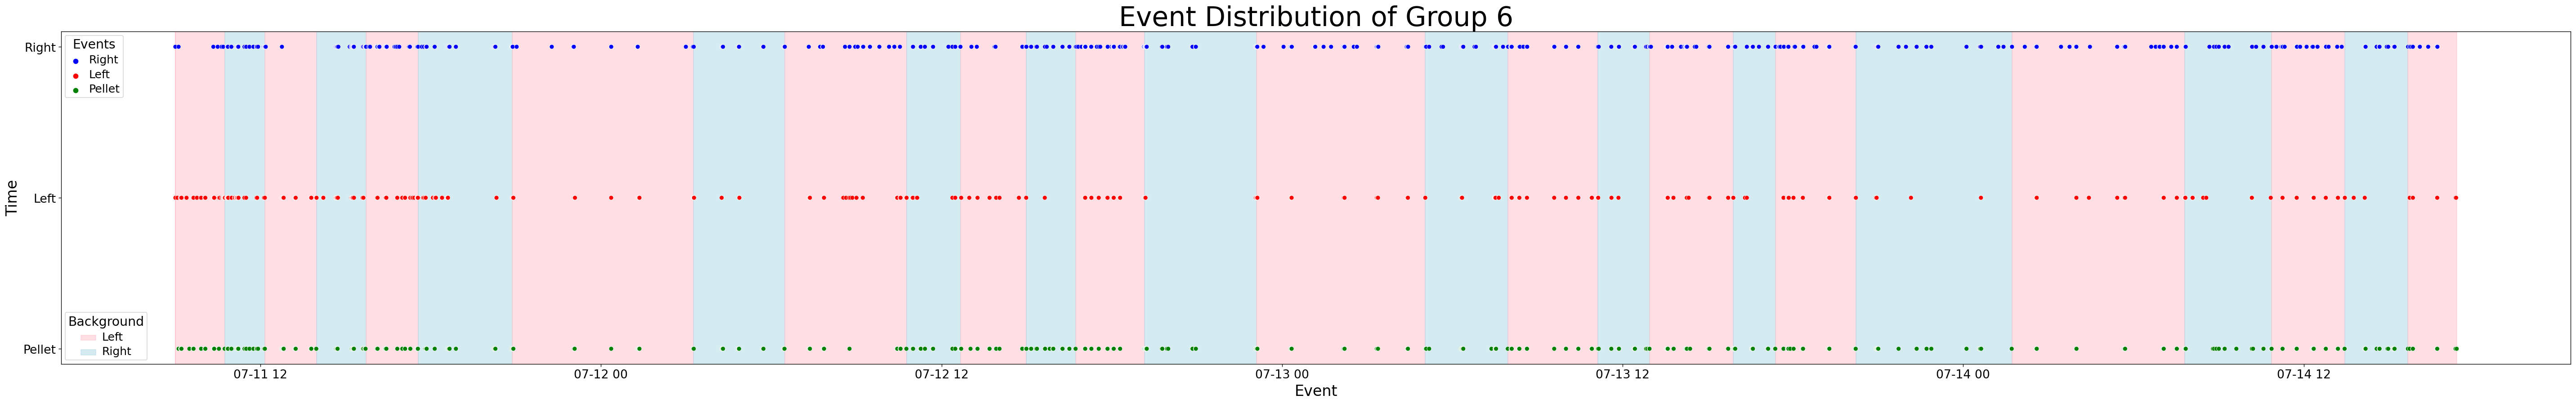

In [29]:
colors = {'Left': 'red', 'Right': 'blue', 'Pellet': 'green'}

# Create a custom background for alternating 'Left' and 'Right' values
fig, ax = plt.subplots(figsize=(60, 8))
sns.scatterplot(data=data_dropped, x='Time_Stamp', y='Event',
                hue='Event', palette=colors, ax=ax, zorder=2)

# Fill the background with pink for 'Left' and blue for 'Right'
left_color = 'pink'
right_color = 'lightblue'

# Find regions where 'Active_Poke' is continuous for at least 10 time stamps
active_regions = []
current_region = data_dropped['Time_Stamp'][0]
current_poke = None
for idx, row in data_dropped.iterrows():
    # if last element equal to current, we expand current region
    if current_poke == row['Active_Poke']:
        continue
    # change in value, we move current to active_regions, and reset current region
    else:
        color = 'pink' if data_dropped['Active_Poke'].loc[data_dropped['Time_Stamp']
                                                          == current_region].iloc[0] == 'Left' else 'lightblue'
        ax.axvspan(current_region, row['Time_Stamp'],
                   color=color, alpha=0.5, zorder=1)

        current_region = row['Time_Stamp']

        current_poke = 'Left' if current_poke == 'Right' else 'Right'

color = 'pink' if data_dropped['Active_Poke'].loc[data_dropped['Time_Stamp']
                                                  == current_region].iloc[0] == 'Left' else 'lightblue'
ax.axvspan(current_region, data_dropped['Time_Stamp'][len(
        data_dropped['Time_Stamp']) - 1], color=color, alpha=0.5, zorder=1)

# Define legend patches and labels for the background colors
left_patch = mpatches.Patch(color='pink', alpha=0.5, label='Left')
right_patch = mpatches.Patch(color='lightblue', alpha=0.5, label='Right')

# save a copy for original legend and create new legend for bg-color
legend = plt.legend(title='Events', loc='upper left')
leg_bg = plt.legend(handles=[left_patch, right_patch], loc='lower left')

# set style for new legend
leg_bg.set_title('Background')
leg_bg.get_title().set_fontsize('17')
leg_bg.get_texts()[0].set_fontsize('15')
leg_bg.get_texts()[1].set_fontsize('15')

# Combine the legends into one
ax = plt.gca()
ax.add_artist(legend)

# set original legend style
legend.get_title().set_fontsize('17')
legend.get_texts()[0].set_fontsize('15')
legend.get_texts()[1].set_fontsize('15')
legend.get_texts()[2].set_fontsize('15')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Event Distribution of Group 6', fontsize=36)
plt.xlabel('Event', fontsize=20)
plt.ylabel('Time', fontsize=20)
plt.show()


### Statistical Analysis

#### Split the data set into array of blocks

In [30]:
def split_data_to_blocks(data_dropped):
    data_dropped = data_dropped.dropna()
    curr_poke = data_dropped['Active_Poke'][0]
    blocks = []
    start_idx = 0

    for key, val in data_dropped.iterrows():
        if val['Active_Poke'] != curr_poke:
            blocks.append(data_dropped.iloc[start_idx:key])  # add current block
            start_idx = key # update start_idx
            curr_poke = val['Active_Poke']   # update poke marker

    blocks.append(df.iloc[start_idx:])  # append the last block
    return blocks

In [31]:
data_dropped.head()

,Time_Stamp,Event,Active_Poke
0,2023-07-11 09:00:03,Right,Left
1,2023-07-11 09:00:06,Left,Left
2,2023-07-11 09:04:12,Left,Left
3,2023-07-11 09:06:50,Right,Left
4,2023-07-11 09:06:51,Pellet,Left


In [32]:
blocks = split_data_to_blocks(data_dropped)

temp = df[['MM:DD:YYYY hh:mm:ss', 'Event', 'Active_Poke']].rename(
        columns={'MM:DD:YYYY hh:mm:ss': 'Time_Stamp'})
pellet_blocks = split_data_to_blocks(temp)

#### Count number of different cases
We need R-R, R-L, L-L, L-R

Create helper function that perform unit count for each sub-frame

In [33]:
def count_transitions(sub_frame):
    transitions = {
        'Left_to_Left': 0,
        'Left_to_Right': 0,
        'Right_to_Right': 0,
        'Right_to_Left': 0,
        'success_count' : 0,
    }
    
    prev_event = None
    
    for _, row in sub_frame.iterrows():
        event = row['Event']

        if prev_event is not None:
            transition = f"{prev_event}_to_{event}"
            if transition in transitions:
                transitions[transition] += 1
        
        if event == row['Active_Poke']:
            transitions['success_count'] += 1

        prev_event = event
    
    return transitions

In [34]:
def count_pellet(sub_frame):
    pellet_count = 0
    
    for _, row in sub_frame.iterrows():
        event = row['Event']
        
        if 'Pellet' in event:
            pellet_count += 1
    
    return pellet_count

Counting Cycle

In [35]:
# Iterate through sub-frames and count transitions for each
# Note: if the event matches current active poke or the 
new_add = []

for i, block in enumerate(blocks):
    size = len(block)
    transitions = count_transitions(block)
    active_poke = block.iloc[0]['Active_Poke']
    new_row_data = {
        'Block_Index': i+1,
        'Left_to_Left': round(transitions.get('Left_to_Left')/size * 100, 2),
        'Left_to_Right': round(transitions.get('Left_to_Right')/size * 100, 2),
        'Right_to_Right': round(transitions.get('Right_to_Right')/size * 100, 2),
        'Right_to_Left': round(transitions.get('Right_to_Left')/size * 100, 2),
        'Success_Count': transitions.get('success_count'),
        'Success_Rate' : round(transitions.get('success_count')/size * 100, 2),
        'Active_Poke' : active_poke,
        'Total_Count': size
    }
    new_add.append(new_row_data)

idx = 0
for each in new_add:
    count = count_pellet(pellet_blocks[idx])
    each['Pellet_Rate'] = round(count / len(pellet_blocks[idx]), 2)
    idx += 1
    

data_stats = pd.DataFrame(new_add, columns=[
    'Block_Index', 'Left_to_Left', 'Left_to_Right', 'Right_to_Right', 'Right_to_Left',
    'Success_Count', 'Success_Rate','Active_Poke', 'Total_Count', 'Pellet_Rate'])

data_stats.to_csv('FED_'+group_name+'_stats.csv', index=False)


In [36]:
# data checker
data_stats.head()

,Block_Index,Left_to_Left,Left_to_Right,Right_to_Right,Right_to_Left,Success_Count,Success_Rate,Active_Poke,Total_Count,Pellet_Rate
0,1,39.80,3.06,1.02,5.10,66,67.35,Left,98,0.68
1,2,45.45,9.92,3.31,0.00,29,23.97,Right,121,0.23
2,3,6.06,0.00,13.64,4.55,29,43.94,Left,66,0.38
3,4,44.35,8.87,4.84,1.61,31,25.00,Right,124,0.23
4,5,2.78,0.00,37.96,12.96,28,25.93,Left,108,0.25


#### Graph of Statstical Data

##### Transition and Success Rate Graph

In [49]:
print(blocks[14])

              Time_Stamp   Event Active_Poke
1230 2023-07-12 23:05:38   Right        Left
1231 2023-07-12 23:05:45   Right        Left
1232 2023-07-12 23:05:48   Right        Left
1233 2023-07-12 23:05:50   Right        Left
1234 2023-07-12 23:05:53   Right        Left
...                  ...     ...         ...
1338 2023-07-13 04:26:24   Right        Left
1339 2023-07-13 05:02:05   Right        Left
1340 2023-07-13 05:02:08   Right        Left
1341 2023-07-13 05:02:15    Left        Left
1342 2023-07-13 05:02:16  Pellet        Left

[113 rows x 3 columns]


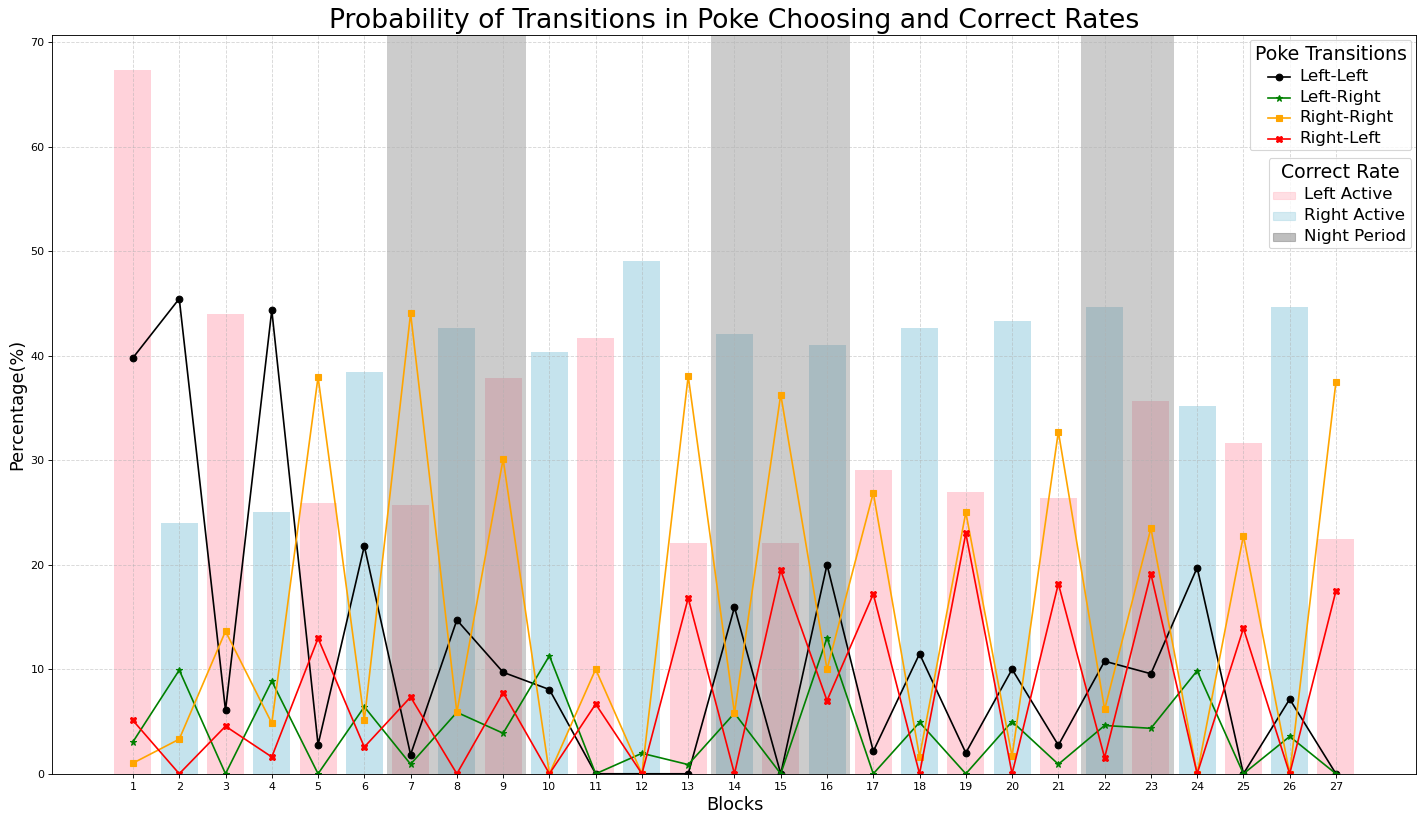

In [48]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(22, 12))

# Line plots for transitions
ax.plot(data_stats['Block_Index'], data_stats['Left_to_Left'],
        marker='o', label='Left-Left', color='black')
ax.plot(data_stats['Block_Index'], data_stats['Left_to_Right'],
        marker='*', label='Left-Right', color='green')
ax.plot(data_stats['Block_Index'], data_stats['Right_to_Right'],
        marker='s', label='Right-Right', color='orange')
ax.plot(data_stats['Block_Index'], data_stats['Right_to_Left'],
        marker='X', label='Right-Left', color='red')

# save a copy for original legend and create new legend for bg-color
legend = plt.legend(title='Poke Transitions', loc='upper right')

# Bar plot on the same y-axis
ax.bar(data_stats['Block_Index'][::2], data_stats['Success_Rate'][::2],
       label='Success Rate', color='pink', alpha=0.7)
ax.bar(data_stats['Block_Index'][1::2], data_stats['Success_Rate'][1::2],
       label='Success Rate', color='lightblue', alpha=0.7)

# Set labels for the y-axis
ax.set_xlabel('Blocks', fontsize=16)
ax.set_ylabel('Percentage(%)', color='black', fontsize=16)

# set original legend style
legend.get_title().set_fontsize('17')
for text in legend.get_texts():
    text.set_fontsize('15')

# Determine night blocks based on the first timestamp in each block
night_blocks = []
block_start_index = 1  # Initialize the starting block index

for block_df in blocks:
    if not block_df.empty and 'Time_Stamp' in block_df:
        first_timestamp = pd.to_datetime(block_df['Time_Stamp'].iloc[0])
        if 19 <= first_timestamp.hour or first_timestamp.hour < 7:
            night_blocks.append(block_start_index)
    block_start_index += 1

# Shade the night blocks in gray
for block_index in night_blocks:
    ax.axvspan(block_index - 0.5, block_index + 0.5, facecolor='gray', alpha=0.4)

# Define legend patches and labels for the background colors
left_patch = mpatches.Patch(color='pink', alpha=0.5, label='Left Active')
right_patch = mpatches.Patch(color='lightblue', alpha=0.5, label='Right Active')
night_patch = mpatches.Patch(color='gray', alpha=0.5, label='Night Period')

# create new legend
leg_bg = plt.legend(handles=[left_patch, right_patch, night_patch], loc='upper right', bbox_to_anchor=(1.0, 0.84))

# set style for new legend
leg_bg.set_title('Correct Rate')
leg_bg.get_title().set_fontsize('17')
leg_bg.get_texts()[0].set_fontsize('15')
leg_bg.get_texts()[1].set_fontsize('15')
leg_bg.get_texts()[2].set_fontsize('15')

# Combine the legends into one
ax = plt.gca()
ax.add_artist(legend)

# plot setting
plt.title('Probability of Transitions in Poke Choosing and Correct Rates', fontsize=24)
plt.xticks(data_stats['Block_Index'])
fig.set_dpi(80)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

### Pellet Rate Graph

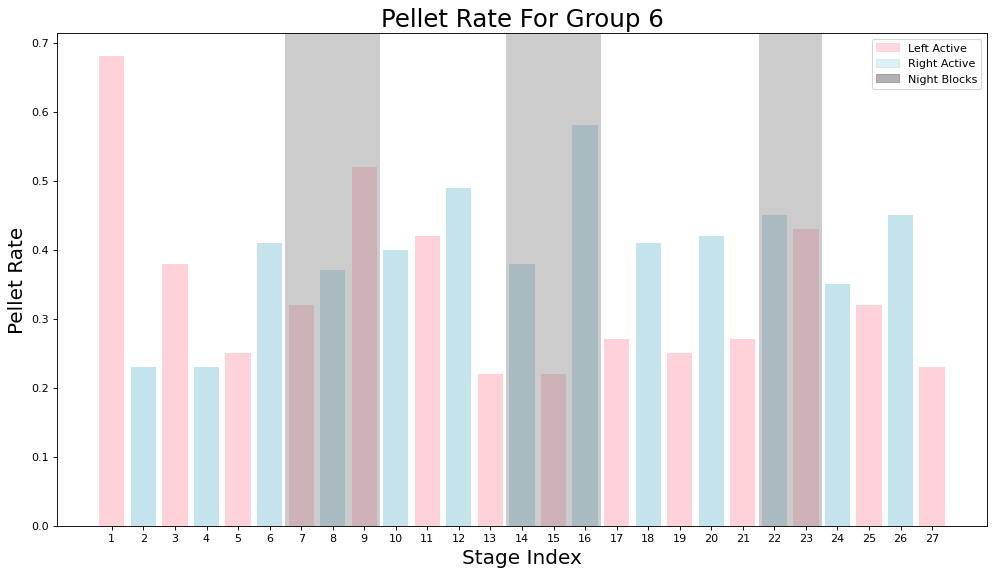

In [38]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=80)

ax.bar(data_stats['Block_Index'][::2], data_stats['Pellet_Rate']
       [::2], label='Left Active', color='pink', alpha=0.7)
ax.bar(data_stats['Block_Index'][1::2], data_stats['Pellet_Rate']
       [1::2], label='Right Active', color='lightblue', alpha=0.7)

plt.title('Pellet Rate For Group 6', fontsize=22)
plt.xlabel('Stage Index', fontsize=18)
plt.ylabel('Pellet Rate', fontsize=18)
plt.xticks(range(1, 28))

# Determine night blocks based on the first timestamp in each block
night_blocks = []
block_start_index = 1  # Initialize the starting block index

for block_df in blocks:
    if not block_df.empty and 'Time_Stamp' in block_df:
        first_timestamp = pd.to_datetime(block_df['Time_Stamp'].iloc[0])
        if 19 <= first_timestamp.hour or first_timestamp.hour < 7:
            night_blocks.append(block_start_index)
    block_start_index += 1

# Shade the night blocks in gray
for block_index in night_blocks:
    ax.axvspan(block_index - 0.5, block_index + 0.5, facecolor='gray', alpha=0.4)

night_patch = mpatches.Patch(color='gray', alpha=0.6, label='Night Blocks')
left_patch = mpatches.Patch(color='pink', alpha=0.6, label='Left Active')
right_patch = mpatches.Patch(color='lightblue', alpha=0.4, label='Right Active')

plt.legend(handles=[left_patch, right_patch, night_patch])
plt.show()

#### Success Rate and Pellet Rate correlation

In [39]:
data_stats['Pellet_Rate'] *= 100

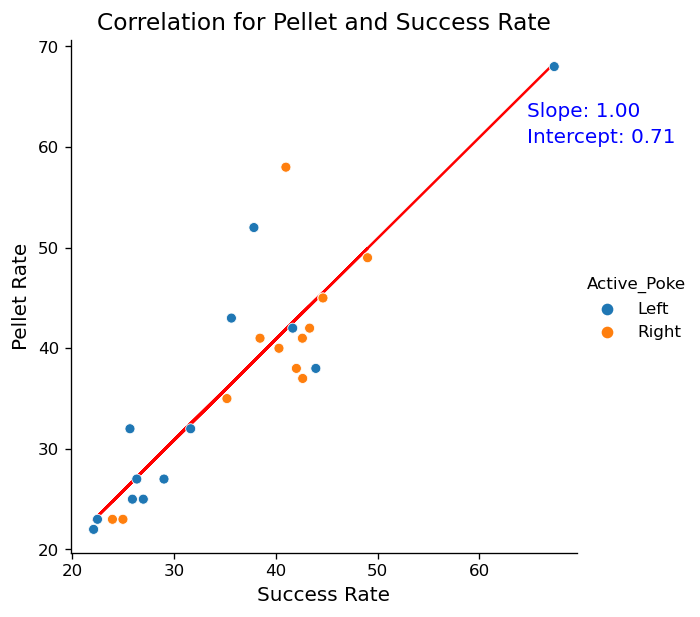

In [40]:
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.dpi'] = 120

sns.relplot(data=data_stats, x='Success_Rate',
            y='Pellet_Rate', hue='Active_Poke', zorder=2)

lin = LinearRegression()
X = data_stats['Success_Rate'].values.reshape(-1, 1)
y = data_stats['Pellet_Rate'].values
lin.fit(X, y)
y_pred = lin.predict(X)
plt.plot(X, y_pred, color='red', zorder=1)

# Get the slope and intercept values
slope = lin.coef_[0]
intercept = lin.intercept_

# Add annotations for slope and intercept
plt.annotate(f'Slope: {slope:.2f}', xy=(0.9, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'Intercept: {intercept:.2f}', xy=(0.9, 0.8), xycoords='axes fraction', fontsize=12, color='blue')
plt.xlabel('Success Rate', fontsize=12)
plt.ylabel('Pellet Rate', fontsize=12)
plt.title('Correlation for Pellet and Success Rate', fontsize=14)
plt.show()
